# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [ ]:
df = pd.read_json('/content/drive/MyDrive/sercasm/twitter/sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)
df1 = pd.read_json('/content/drive/MyDrive/sercasm/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl',lines=True)

df['labels'] = df['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1['labels'] = df1['label'].apply(lambda x: ['SARCASM', 'NOT_SARCASM'].index(x))
df1.tail()

,label,context,response,id,labels
1795,NOT_SARCASM,[I have been a business customer of MWeb @USER...,@USER @USER @USER is definitely the best out t...,twitter_1796,1
1796,SARCASM,[A woman refuses to have her temperature taken...,@USER @USER Ye let her out run wild and infect...,twitter_1797,0
1797,SARCASM,[The reason big government wants @USER out is ...,"@USER @USER @USER Thanks for that , I would ha...",twitter_1798,0
1798,NOT_SARCASM,[Happy #musicmonday and #thanks for #all your ...,@USER @USER @USER Yes also #found this on #new...,twitter_1799,1
1799,NOT_SARCASM,[Not long wrapped on the amazing #January22nd ...,@USER @USER @USER you still need to send the l...,twitter_1800,1


In [ ]:
df["tweets"]=df['response']
df1["tweets"]=df1['response']

In [ ]:
df.shape

(5000, 5)

In [ ]:
# check class distribution
df['labels'].value_counts(normalize = True)

1    0.5
0    0.5
Name: labels, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:

X_s = df['tweets'].values
y_s = df['labels'].values

Xt_s = df1['tweets'].values
yt_s = df1['labels'].values

train_text, temp_text, train_labels, temp_labels = X_s,Xt_s,y_s,yt_s

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)
val_text, test_text, val_labels, test_labels=temp_text, temp_text, temp_labels, temp_labels

# X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)


In [ ]:
# pip install -U sentence-transformers

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

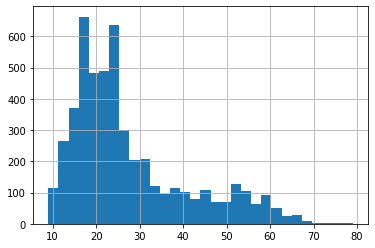

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 100

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True
# print(bert)

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id,mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
epochs=3
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss,_ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    #load weights of best model
    path = 'saved_weights.pt'
    model.load_state_dict(torch.load(path))
    with torch.no_grad():
      preds = model(test_seq.to(device), test_mask.to(device))
      preds = preds.detach().cpu().numpy()
    # model's performance
    preds = np.argmax(preds, axis = 1)
    print(classification_report(test_y, preds))
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...
  Batch    50  of     57.
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       900
           1       0.74      0.66      0.70       900

    accuracy                           0.72      1800
   macro avg       0.72      0.72      0.72      1800
weighted avg       0.72      0.72      0.72      1800


Training Loss: 0.536
Validation Loss: 0.573

 Epoch 2 / 3
  Batch    50  of    157.
  Batch   100  of    157.
  Batch   150  of    157.

Evaluating...
  Batch    50  of     57.
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       900
           1       0.74      0.66      0.70       900

    accuracy                           0.72      1800
   macro avg       0.72      0.72      0.72      1800
weighted avg       0.72      0.72      0.72      1800


Training Loss: 0.387
Validation Lo

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
print(preds)
p = torch.nn.functional.softmax(preds, dim=1)
# df = pd.DataFrame(preds)
# df.to_csv("bert.csv")
print(p)

[[-0.7890497  -0.60564244]
 [-0.26606497 -1.4540995 ]
 [-0.2394344  -1.5468054 ]
 ...
 [-0.5602411  -0.8464649 ]
 [-3.0385964  -0.04908742]
 [-3.1298473  -0.04470916]]


In [ ]:
import scipy.special.softmax as softmax


In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
# print(classification_report(test_y, preds))

In [ ]:
# confusion matrix
# # pd.crosstab(test_y, preds)
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# print(accuracy_score(test_y, preds))

# SVC

In [ ]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
!pip install demoji
import demoji
demoji.download_codes()
nltk.download('stopwords') 
nltk.download('wordnet')

... OK (Got response in 0.21 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df['context_resp']=df['label']
for i in range(5000):
  df['context_resp'][i]=''.join(df['context'][i]) + df['response'][i]

print(df['context'][12])
print(df['response'][12])
print(df['context_resp'][12])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['Matt here . Rarely comment on the president , but having someone who is not Jewish tell Jews what they should or shouldn ’ t think is beyond the pale and it should not go unchallenged . <URL>', '@USER It seems there is a long history of non-Jews telling Jews what to think .']
@USER @USER Hey , but what do they have to lose ? Asking for some black friends .
Matt here . Rarely comment on the president , but having someone who is not Jewish tell Jews what they should or shouldn ’ t think is beyond the pale and it should not go unchallenged . <URL>@USER It seems there is a long history of non-Jews telling Jews what to think .@USER @USER Hey , but what do they have to lose ? Asking for some black friends .


In [ ]:
def preprocess_text(text):
    # Tokenise words while ignoring punctuation(https://www.nltk.org/_modules/nltk/tokenize/regexp.html)
    text = re.sub(r"@USER","", text)
    text = re.sub(r'<URL>','',text)
    text = demoji.replace_with_desc(text)
    text = re.sub(r':','',text)
    # tokeniser = RegexpTokenizer(r'\s+', gaps=True)
    # tokeniser = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)

    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    
    # stemming
    ps=PorterStemmer()
    keywords=[ps.stem(x) for x in keywords]
    return keywords

def preprocess_text2(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation (optional)
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [ ]:
for i in range(5):
  print(df['response'][i])
  print(preprocess_text(df['response'][i]))
  print(preprocess_text2(df['response'][i]))
  print()
  print(df['context_resp'][i])
  print(preprocess_text(df['context_resp'][i]))
  print(preprocess_text2(df['context_resp'][i]))
  print()

@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..
['get', 'obvious', 'care', 'would', 'move', 'right', 'along', 'instead', 'decid', 'care', 'troll']
['get', '..', 'obvious', 'care', "would'v", 'move', 'right', 'along', '..', 'instead', 'decid', 'care', 'troll', '..']

A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..
['minor', 'child', 'deserv', 'privaci', 'keep', 'polit', 'pamela', 'karlan', 'asham', 'angri', 'obvious', 'bia', 'public', 'pander', 'use', 'child', 'child', 'name', 'barron', 'bebest', 'melania', 'care', 'less', 'fa

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
print(df['label'].value_counts())
print(df1['label'].value_counts())

NOT_SARCASM    2500
SARCASM        2500
Name: label, dtype: int64
SARCASM        900
NOT_SARCASM    900
Name: label, dtype: int64


In [ ]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(df['response'],df['label'],random_state=123)
X_test_svm, Y_test = df1['response'],df1['label']

In [ ]:
pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [ ]:
from sentence_transformers import SentenceTransformer
# sbert_model = SentenceTransformer('stsb-mpnet-base-v2')
sbert_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

NameError: ignored

In [ ]:
# sgd_clf = SGDClassifier(random_state=123)
from tqdm.auto import tqdm
import numpy as np
query = "I had pizza and pasta"
# sentence_embeddings = sbert_model.encode(query) 
sentence_embeddings = [sbert_model.encode(i.lower()) for i in tqdm(X_train)]

In [ ]:
query = "I had pizza and pasta"
# sentence_embeddings = sbert_model.encode(query) 
test_embeddings = [sbert_model.encode(i.lower()) for i in tqdm(X_test_svm)]

In [ ]:
sentence_embeddings=np.array(sentence_embeddings)
test_embeddings=np.array(test_embeddings)

In [ ]:
# X_train2, X_test2, Y_train2, Y_test2=train_test_split(sentence_embeddings,Y_train,random_state=42)
X_train2, X_test2, Y_train2, Y_test2=sentence_embeddings, test_embeddings, Y_train, Y_test

In [ ]:
X_test_=test_embeddings

In [ ]:
from sklearn.svm import SVC
model= SVC(random_state=24,probability=True)

model.fit(sentence_embeddings, Y_train) # fit the model
y_pred= model.predict(test_embeddings) # then predict on the test set
accuracy= accuracy_score(Y_test, y_pred) # this gives us how often the algorithm predicted correctly
# clf_report= classification_report(Y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
# print(clf_report)
print("\n")

In [ ]:
pr=model.predict_proba(test_embeddings)
pr

In [ ]:
pr2=np.subtract(pr,1)
pr3=np.multiply(pr2,-1)
pr3

#Ensemble

In [ ]:
yhats = [preds,pr3]
import numpy as np
yhats = np.array(yhats)
# sum across ensemble members
summed = np.sum(yhats, axis=0)
# argmax across classes
result = np.argmax(summed, axis=1)
# return result
print(result)
print(testing)
# # evaluate a specific number of members in an ensemble
# def evaluate_n_members(members, n_members, testX, testy):
# 	# select a subset of members
# 	subset = members[:n_members]
# 	print(len(subset))
# 	# make prediction
# 	yhat = ensemble_predictions(subset, testX)
# 	# calculate accuracy
accuracy_score(result, testing)